<a href="https://colab.research.google.com/github/Gwidi/CEM_MPC/blob/main/CEM_MPC.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Całość kodu

/usr/local/lib/python3.11/dist-packages/gym/spaces/box.py:128: UserWarning: WARN: Box bound precision lowered by casting to float32
  logger.warn(f"Box bound precision lowered by casting to {self.dtype}")


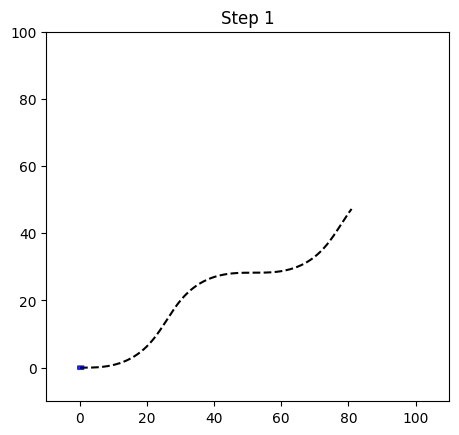

In [ ]:
import gym
from gym import spaces
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.patches import Rectangle

# --- Model Pojazdu ---
class BicycleModelCurvilinear:
    def __init__(self):
        self.m = 230         # masa [kg]
        self.Iz = 108.5      # bezwładność [kg m^2]
        self.lF = 0.9
        self.lR = 1.0
        self.L = self.lF + self.lR
        self.Cm = 0.3 * self.m
        self.Cr0 = 50
        self.Cr2 = 0.5
        self.Bf, self.Cf, self.Df = 10.0, 1.3, 1.0 * self.m * 9.81 * self.lR / self.L
        self.Br, self.Cr, self.Dr = 12.0, 1.3, 1.0 * self.m * 9.81 * self.lF / self.L
        self.ptv = 3.0

    def tire_forces(self, vx, vy, r, delta):
        alpha_f = np.arctan2(vy + self.lF * r, vx) - delta
        alpha_r = np.arctan2(vy - self.lR * r, vx)
        FyF = self.Df * np.sin(self.Cf * np.arctan(self.Bf * alpha_f))
        FyR = self.Dr * np.sin(self.Cr * np.arctan(self.Br * alpha_r))
        return FyF, FyR

    def longitudinal_force(self, vx, T):
        return self.Cm * T - self.Cr0 - self.Cr2 * vx ** 2

    def tv_moment(self, vx, r, delta):
        rt = np.tan(delta) * vx / self.L
        return self.ptv * (rt - r)

    def dynamics(self, x, u, curvature):
        s, n, mu, vx, vy, r, delta, T = x
        delta_dot, T_dot = u
        FyF, FyR = self.tire_forces(vx, vy, r, delta)
        Fx = self.longitudinal_force(vx, T)
        Mtv = self.tv_moment(vx, r, delta)
        s_dot = (vx * np.cos(mu) - vy * np.sin(mu)) / (1 - curvature * n)
        n_dot = vx * np.sin(mu) + vy * np.cos(mu)
        mu_dot = r - curvature * s_dot
        vx_dot = (Fx - FyF * np.sin(delta) + self.m * vy * r) / self.m
        vy_dot = (FyR + FyF * np.cos(delta) - self.m * vx * r) / self.m
        r_dot = (FyF * self.lF * np.cos(delta) - FyR * self.lR + Mtv) / self.Iz
        return np.array([s_dot, n_dot, mu_dot, vx_dot, vy_dot, r_dot, delta_dot, T_dot])

    def rk4_step(self, x, u, curvature, dt):
        k1 = self.dynamics(x, u, curvature)
        k2 = self.dynamics(x + 0.5 * dt * k1, u, curvature)
        k3 = self.dynamics(x + 0.5 * dt * k2, u, curvature)
        k4 = self.dynamics(x + dt * k3, u, curvature)
        return x + dt / 6 * (k1 + 2*k2 + 2*k3 + k4)

# --- Generator Trasy ---
def generate_test_track(num_points=1000):
    s = np.linspace(0, 100, num_points)
    curvature = 0.05 * np.sin(0.1 * s)
    return s, curvature

# --- Cross-Entropy MPC ---
def cem_control(model, x0, track_s, curvature, horizon=20, dt=0.05,
                num_samples=64, elite_frac=0.2, iters=2):
    mu = np.zeros((horizon, 2))
    sigma = 0.5 * np.ones_like(mu)
    best_seq = None
    best_cost = float('inf')

    for _ in range(iters):
        samples = np.random.randn(num_samples, horizon, 2) * sigma + mu
        costs = np.zeros(num_samples)

        for i in range(num_samples):
            x = x0.copy()
            cost = 0
            for t in range(horizon):
                idx = np.argmin(np.abs(track_s - x[0]))
                curv = curvature[idx]
                u = samples[i, t]
                x = model.rk4_step(x, u, curv, dt)
                n, mu_angle, vx = x[1], x[2], x[3]
                cost += 1.0 * n**2 + 0.5 * mu_angle**2 + 0.05 * np.sum(u**2) - 0.1 * vx
            costs[i] = cost

        elite_idxs = costs.argsort()[:int(elite_frac * num_samples)]
        elite_samples = samples[elite_idxs]
        mu = elite_samples.mean(axis=0)
        sigma = elite_samples.std(axis=0)

        if costs.min() < best_cost:
            best_cost = costs.min()
            best_seq = samples[costs.argmin()]

    return best_seq[0] if best_seq is not None else np.zeros(2)

# --- Środowisko ---
class RaceCarEnv(gym.Env):
    def __init__(self, model, track_s, curvature, dt=0.05, max_steps=200):
        super(RaceCarEnv, self).__init__()

        self.model = model
        self.track_s = track_s
        self.curvature = curvature
        self.dt = dt
        self.max_steps = max_steps

        high_obs = np.array([track_s[-1], 5.0, np.pi, 30.0, 10.0, 5.0, np.pi/4, 1.0])
        self.observation_space = spaces.Box(low=-high_obs, high=high_obs, dtype=np.float32)

        max_delta_dot = 1.0
        max_T_dot = 2.0
        self.action_space = spaces.Box(low=np.array([-max_delta_dot, -max_T_dot]),
                                       high=np.array([max_delta_dot, max_T_dot]), dtype=np.float32)

        self.L = 1.8
        self.W = 1.0

        self._init_render()
        self.reset()

    def reset(self):
        self.state = np.array([0.0, 0.0, 0.0, 5.0, 0.0, 0.0, 0.0, 0.0])
        self.step_count = 0
        return self.state.copy()

    def step(self, action):
        delta_dot, T_dot = action
        u = np.array([delta_dot, T_dot])

        idx = np.argmin(np.abs(self.track_s - self.state[0]))
        curv = self.curvature[idx]
        next_state = self.model.rk4_step(self.state, u, curv, self.dt)

        n, mu, vx = next_state[1], next_state[2], next_state[3]
        cost = 1.0 * n**2 + 0.5 * mu**2 + 0.05 * np.sum(u**2) - 0.1 * vx

        self.state = next_state
        self.step_count += 1
        done = self.step_count >= self.max_steps or self.state[0] >= self.track_s[-1]

        return self.state.copy(), -cost, done, {}

    def _init_render(self):
        self.fig, self.ax = plt.subplots()
        self.car_patch = Rectangle((0, 0), self.L, self.W, color='blue', alpha=0.8)
        self.ax.add_patch(self.car_patch)
        self.ax.set_aspect('equal')
        self.ax.set_xlim(-10, 110)
        self.ax.set_ylim(-10, 100)
        self.track_x, self.track_y = self._compute_reference_track()
        self.ax.plot(self.track_x, self.track_y, 'k--')

    def _compute_reference_track(self):
        ds = self.track_s[1] - self.track_s[0]
        theta = np.cumsum(self.curvature) * ds
        x = np.cumsum(np.cos(theta) * ds)
        y = np.cumsum(np.sin(theta) * ds)
        return x, y

    def render(self, mode='human'):
        s, n, mu = self.state[0], self.state[1], self.state[2]
        idx = np.argmin(np.abs(self.track_s - s))
        ref_x, ref_y = self.track_x[idx], self.track_y[idx]
        ref_theta = np.sum(self.curvature[:idx]) * (self.track_s[1] - self.track_s[0])
        x_car = ref_x - n * np.sin(ref_theta)
        y_car = ref_y + n * np.cos(ref_theta)
        angle = np.rad2deg(mu + ref_theta)
        self.car_patch.set_xy((x_car - self.L / 2, y_car - self.W / 2))
        self.car_patch.angle = angle

        self.ax.set_title(f"Step {self.step_count}")
        plt.pause(0.001)

    def close(self):
        plt.show(block=True)
        plt.close(self.fig)

model = BicycleModelCurvilinear()
track_s, curvature = generate_test_track()
env = RaceCarEnv(model, track_s, curvature)

obs = env.reset()

for _ in range(200):
    #action = cem_control(model, obs, track_s, curvature)
    action = env.action_space.sample()
    obs, reward, done, _ = env.step(action)
    env.render()
    if done:
      break
env.close()

Stworzenie modelu **Curvilenear Bicycle Model**. Dynamika modelu została opisana w układzie krzywoliniowym, który jest zdefiniowany lokalnie względem zadanej ścieżki referencyjnej. Stan pojazdu zawiera:
postęp wzdłuż toru **s**, prostopadłe odchylenie od toru **n**,lokalny kąt względem kierunku toru **μ**(mu), prędkości **v_x** i **v_y**, prędkość obrotu wokół osi pionowej (yaw rate) **r**, kąt skrętu kół **δ** oraz polecenie kierowcy **T**.


In [ ]:
# --- Model Pojazdu ---
class BicycleModelCurvilinear:
    def __init__(self):
        self.m = 230         # masa [kg]
        self.Iz = 108.5      # bezwładność [kg m^2]
        self.lF = 0.9
        self.lR = 1.0
        self.L = self.lF + self.lR
        self.Cm = 0.3 * self.m
        self.Cr0 = 50
        self.Cr2 = 0.5
        self.Bf, self.Cf, self.Df = 10.0, 1.3, 1.0 * self.m * 9.81 * self.lR / self.L
        self.Br, self.Cr, self.Dr = 12.0, 1.3, 1.0 * self.m * 9.81 * self.lF / self.L
        self.ptv = 3.0

    def tire_forces(self, vx, vy, r, delta):
        alpha_f = np.arctan2(vy + self.lF * r, vx) - delta
        alpha_r = np.arctan2(vy - self.lR * r, vx)
        FyF = self.Df * np.sin(self.Cf * np.arctan(self.Bf * alpha_f))
        FyR = self.Dr * np.sin(self.Cr * np.arctan(self.Br * alpha_r))
        return FyF, FyR

    def longitudinal_force(self, vx, T):
        return self.Cm * T - self.Cr0 - self.Cr2 * vx ** 2

    def tv_moment(self, vx, r, delta):
        rt = np.tan(delta) * vx / self.L
        return self.ptv * (rt - r)

    def dynamics(self, x, u, curvature):
        s, n, mu, vx, vy, r, delta, T = x
        delta_dot, T_dot = u
        FyF, FyR = self.tire_forces(vx, vy, r, delta)
        Fx = self.longitudinal_force(vx, T)
        Mtv = self.tv_moment(vx, r, delta)
        s_dot = (vx * np.cos(mu) - vy * np.sin(mu)) / (1 - curvature * n)
        n_dot = vx * np.sin(mu) + vy * np.cos(mu)
        mu_dot = r - curvature * s_dot
        vx_dot = (Fx - FyF * np.sin(delta) + self.m * vy * r) / self.m
        vy_dot = (FyR + FyF * np.cos(delta) - self.m * vx * r) / self.m
        r_dot = (FyF * self.lF * np.cos(delta) - FyR * self.lR + Mtv) / self.Iz
        return np.array([s_dot, n_dot, mu_dot, vx_dot, vy_dot, r_dot, delta_dot, T_dot])

    def rk4_step(self, x, u, curvature, dt):
        k1 = self.dynamics(x, u, curvature)
        k2 = self.dynamics(x + 0.5 * dt * k1, u, curvature)
        k3 = self.dynamics(x + 0.5 * dt * k2, u, curvature)
        k4 = self.dynamics(x + dt * k3, u, curvature)
        return x + dt / 6 * (k1 + 2*k2 + 2*k3 + k4)

**rk4_step()** - zwraca nowy stan pojazdu obliczony po czasie **dt** metodą Rungego-Kutty

In [ ]:
import gym
from gym import spaces
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.patches import Rectangle
import colorednoise as cn


# --- Model Pojazdu ---
class BicycleModelCurvilinear:
    def __init__(self):
        self.m = 230         # masa [kg]
        self.Iz = 108.5      # bezwładność [kg m^2]
        self.lF = 0.9
        self.lR = 1.0
        self.L = self.lF + self.lR
        self.Cm = 0.3 * self.m
        self.Cr0 = 50
        self.Cr2 = 0.5
        self.Bf, self.Cf, self.Df = 10.0, 1.3, 1.0 * self.m * 9.81 * self.lR / self.L
        self.Br, self.Cr, self.Dr = 12.0, 1.3, 1.0 * self.m * 9.81 * self.lF / self.L
        self.ptv = 3.0

    def tire_forces(self, vx, vy, r, delta):
        alpha_f = np.arctan2(vy + self.lF * r, vx) - delta
        alpha_r = np.arctan2(vy - self.lR * r, vx)
        FyF = self.Df * np.sin(self.Cf * np.arctan(self.Bf * alpha_f))
        FyR = self.Dr * np.sin(self.Cr * np.arctan(self.Br * alpha_r))
        return FyF, FyR

    def longitudinal_force(self, vx, T):
        return self.Cm * T - self.Cr0 - self.Cr2 * vx ** 2

    def tv_moment(self, vx, r, delta):
        rt = np.tan(delta) * vx / self.L
        return self.ptv * (rt - r)

    def dynamics(self, x, u, curvature):
        s, n, mu, vx, vy, r, delta, T = x
        delta_dot, T_dot = u
        FyF, FyR = self.tire_forces(vx, vy, r, delta)
        Fx = self.longitudinal_force(vx, T)
        Mtv = self.tv_moment(vx, r, delta)
        s_dot = (vx * np.cos(mu) - vy * np.sin(mu)) / (1 - curvature * n)
        n_dot = vx * np.sin(mu) + vy * np.cos(mu)
        mu_dot = r - curvature * s_dot
        vx_dot = (Fx - FyF * np.sin(delta) + self.m * vy * r) / self.m
        vy_dot = (FyR + FyF * np.cos(delta) - self.m * vx * r) / self.m
        r_dot = (FyF * self.lF * np.cos(delta) - FyR * self.lR + Mtv) / self.Iz
        return np.array([s_dot, n_dot, mu_dot, vx_dot, vy_dot, r_dot, delta_dot, T_dot])

    def rk4_step(self, x, u, curvature, dt):
        k1 = self.dynamics(x, u, curvature)
        k2 = self.dynamics(x + 0.5 * dt * k1, u, curvature)
        k3 = self.dynamics(x + 0.5 * dt * k2, u, curvature)
        k4 = self.dynamics(x + dt * k3, u, curvature)
        return x + dt / 6 * (k1 + 2*k2 + 2*k3 + k4)

# --- Generator Trasy ---
def generate_test_track(num_points=1000):
    s = np.linspace(0, 100, num_points)
    curvature = 0.05 * np.sin(0.1 * s)
    return s, curvature
def j_LTO(x, u, dt, R, model, q_beta):
    """
    Evaluate the j_LTO function.

    Parameters:
    - x_k: np.array, the state vector at step k
    - u_k: np.array, the control vector at step k
    - delta_s: float, the step size Δs
    - s_dot_k: float, the speed at step k (dot{s}_k)
    - R: np.array, weight matrix for the control vector
    - B_func: function, computes B(x_k)

    Returns:
    - j_lto: float, the evaluated cost
    """
    term1 = -dt * x[0]
    term2 = u.T @ R @ u
    beta_dyn = np.arctan(x[4] / x[3])

    beta_kin = np.arctan((x[6] * model.lR) / (model.lF + model.lR))

    term3 = q_beta * (beta_dyn - beta_kin) ** 2


    return term1 + term2 + term3
# --- Cross-Entropy MPC ---
def cem_control(model, x0, track_s, curvature, horizon=20, dt=0.05,
                samples=64, elite_frac=0.2, iters=2):

    beta = 1 # the exponent
    actions = cn.powerlaw_psd_gaussian(beta, samples)
    nextstates=[]
    costs =[]
    for x in actions:
        nextstates.append(model.rk4_step(x0,curvature,x,dt))
    for x,y in zip(nextstates,actions):
        costs.append(j_LTO(x,y,dt,np.eye(len(x0))))
    eliteuntruncated=[x for (_,x) in sorted(zip(costs, actions), key=lambda pair: pair[0])]
    elitetruncated=eliteuntruncated[0:round(elite_frac*len(eliteuntruncated))]
    mu=np.mean(elitetruncated)
    std=np.std(elitetruncated)



    return [mu,std]

# --- Środowisko ---
class RaceCarEnv(gym.Env):
    def __init__(self, model, track_s, curvature, dt=0.05, max_steps=200):
        super(RaceCarEnv, self).__init__()

        self.model = model
        self.track_s = track_s
        self.curvature = curvature
        self.dt = dt
        self.max_steps = max_steps

        high_obs = np.array([track_s[-1], 5.0, np.pi, 30.0, 10.0, 5.0, np.pi/4, 1.0])
        self.observation_space = spaces.Box(low=-high_obs, high=high_obs, dtype=np.float32)

        max_delta_dot = 1.0
        max_T_dot = 2.0
        self.action_space = spaces.Box(low=np.array([-max_delta_dot, -max_T_dot]),
                                       high=np.array([max_delta_dot, max_T_dot]), dtype=np.float32)

        self.L = 1.8
        self.W = 1.0

        self._init_render()
        self.reset()

    def reset(self):
        self.state = np.array([0.0, 0.0, 0.0, 5.0, 0.0, 0.0, 0.0, 0.0])
        self.step_count = 0
        return self.state.copy()

    def step(self, action):
        delta_dot, T_dot = action
        u = np.array([delta_dot, T_dot])

        idx = np.argmin(np.abs(self.track_s - self.state[0]))
        curv = self.curvature[idx]
        next_state = self.model.rk4_step(self.state, u, curv, self.dt)

        n, mu, vx = next_state[1], next_state[2], next_state[3]
        cost = 1.0 * n**2 + 0.5 * mu**2 + 0.05 * np.sum(u**2) - 0.1 * vx

        self.state = next_state
        self.step_count += 1
        done = self.step_count >= self.max_steps or self.state[0] >= self.track_s[-1]

        return self.state.copy(), -cost, done, {}

    def _init_render(self):
        self.fig, self.ax = plt.subplots()
        self.car_patch = Rectangle((0, 0), self.L, self.W, color='blue', alpha=0.8)
        self.ax.add_patch(self.car_patch)
        self.ax.set_aspect('equal')
        self.ax.set_xlim(-10, 110)
        self.ax.set_ylim(-10, 100)
        self.track_x, self.track_y = self._compute_reference_track()
        self.ax.plot(self.track_x, self.track_y, 'k--')

    def _compute_reference_track(self):
        ds = self.track_s[1] - self.track_s[0]
        theta = np.cumsum(self.curvature) * ds
        x = np.cumsum(np.cos(theta) * ds)
        y = np.cumsum(np.sin(theta) * ds)
        return x, y

    def render(self, mode='human'):
        s, n, mu = self.state[0], self.state[1], self.state[2]
        idx = np.argmin(np.abs(self.track_s - s))
        ref_x, ref_y = self.track_x[idx], self.track_y[idx]
        ref_theta = np.sum(self.curvature[:idx]) * (self.track_s[1] - self.track_s[0])
        x_car = ref_x - n * np.sin(ref_theta)
        y_car = ref_y + n * np.cos(ref_theta)
        angle = np.rad2deg(mu + ref_theta)
        self.car_patch.set_xy((x_car - self.L / 2, y_car - self.W / 2))
        self.car_patch.angle = angle

        self.ax.set_title(f"Step {self.step_count}")
        plt.pause(0.001)

    def close(self):
        plt.show(block=True)
        plt.close(self.fig)

model = BicycleModelCurvilinear()
track_s, curvature = generate_test_track()
env = RaceCarEnv(model, track_s, curvature)

obs = env.reset()

for _ in range(200):
    #action = cem_control(model, obs, track_s, curvature)
    action = env.action_space.sample()
    obs, reward, done, _ = env.step(action)
    env.render()
    if done:
      break
env.close()

Nowa wersja poniżej

In [ ]:
import gym
from gym import spaces
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.patches import Rectangle
import colorednoise as cn


# --- Model Pojazdu ---
class BicycleModelCurvilinear:
    def __init__(self):
        self.m = 230         # masa [kg]
        self.Iz = 108.5      # bezwładność [kg m^2]
        self.lF = 0.9
        self.lR = 1.0
        self.L = self.lF + self.lR
        self.Cm = 0.3 * self.m
        self.Cr0 = 50
        self.Cr2 = 0.5
        self.Bf, self.Cf, self.Df = 10.0, 1.3, 1.0 * self.m * 9.81 * self.lR / self.L
        self.Br, self.Cr, self.Dr = 12.0, 1.3, 1.0 * self.m * 9.81 * self.lF / self.L
        self.ptv = 3.0

    def tire_forces(self, vx, vy, r, delta):
        alpha_f = np.arctan2(vy + self.lF * r, vx) - delta
        alpha_r = np.arctan2(vy - self.lR * r, vx)
        FyF = self.Df * np.sin(self.Cf * np.arctan(self.Bf * alpha_f))
        FyR = self.Dr * np.sin(self.Cr * np.arctan(self.Br * alpha_r))
        return FyF, FyR

    def longitudinal_force(self, vx, T):
        return self.Cm * T - self.Cr0 - self.Cr2 * vx ** 2

    def tv_moment(self, vx, r, delta):
        rt = np.tan(delta) * vx / self.L
        return self.ptv * (rt - r)

    def dynamics(self, x, u, curvature):
        s, n, mu, vx, vy, r, delta, T = x
        delta_dot, T_dot = u
        FyF, FyR = self.tire_forces(vx, vy, r, delta)
        Fx = self.longitudinal_force(vx, T)
        Mtv = self.tv_moment(vx, r, delta)
        s_dot = (vx * np.cos(mu) - vy * np.sin(mu)) / (1 - curvature * n)
        n_dot = vx * np.sin(mu) + vy * np.cos(mu)
        mu_dot = r - curvature * s_dot
        vx_dot = (Fx - FyF * np.sin(delta) + self.m * vy * r) / self.m
        vy_dot = (FyR + FyF * np.cos(delta) - self.m * vx * r) / self.m
        r_dot = (FyF * self.lF * np.cos(delta) - FyR * self.lR + Mtv) / self.Iz


        return np.array([s_dot, n_dot, mu_dot, vx_dot, vy_dot, r_dot, delta_dot, T_dot])

    def rk4_step(self, x, u, curvature, dt):
        k1 = self.dynamics(x, u, curvature)
        k2 = self.dynamics(x + 0.5 * dt * k1, u, curvature)
        k3 = self.dynamics(x + 0.5 * dt * k2, u, curvature)
        k4 = self.dynamics(x + dt * k3, u, curvature)
        return x + dt / 6 * (k1 + 2*k2 + 2*k3 + k4)

# --- Generator Trasy ---
def generate_test_track(num_points=10000):
    s = np.linspace(0, 320, num_points)
    #curvature = 0.05 * np.sin(0.1 * s)
    curvature=np.ones(num_points)*0.02
    return s, curvature
def j_LTO(x, u, dt, R, model, q_beta=0.5):
    """
    Evaluate the j_LTO function.

    Parameters:
    - x_k: np.array, the state vector at step k
    - u_k: np.array, the control vector at step k
    - delta_s: float, the step size Δs
    - s_dot_k: float, the speed at step k (dot{s}_k)
    - R: np.array, weight matrix for the control vector
    - B_func: function, computes B(x_k)

    Returns:
    - j_lto: float, the evaluated cost
    """
    term1 = -dt * x[0]
    term2 = u.T @ R @ u
    beta_dyn = np.arctan(x[4] / x[3])

    beta_kin = np.arctan((x[6] * model.lR) / (model.lF + model.lR))

    term3 = q_beta * (beta_dyn - beta_kin) ** 2


    return term1 + term2 + term3
# --- Cross-Entropy MPC ---
def cem_control(model, x0, track_s, curvature, dt=0.05,
                samples=64, elite_frac=0.2,iterations=2, dTupper=1,dTlower=-1, ddeltaupper=1, ddeltalower=-1):
    beta = 1 # the exponent
    for i in range(iterations):
        muddelta,mudT=np.mean([[ddeltalower,ddeltaupper],[dTlower,dTupper]],axis=1)
        stdddelta,stddT=[[abs(ddeltalower-ddeltaupper)/2],[abs(dTlower-dTupper)/2]]
        actionsdT = cn.powerlaw_psd_gaussian(beta, samples)
        actionsdT=actionsdT*stddT+mudT
        actions=np.clip(actionsdT,dTlower,dTupper)
        actionsddelta = cn.powerlaw_psd_gaussian(beta, samples)
        actionsddelta=actionsddelta*stdddelta+muddelta
        actionsddelta=np.clip(actionsddelta,ddeltalower,ddeltaupper)
        actions=np.transpose([actionsddelta,actionsdT])
        nextstates=[]
        costs =[]
        for x in actions:
            idx = np.argmin(np.abs(track_s - x0[0]%max(track_s)))
            curv = curvature[idx]
            nextstates.append(model.rk4_step(x0,x,curv,dt))
        for x,y in zip(nextstates,actions):
            costs.append(j_LTO(x,y,dt,np.eye(len(y)),model))
        eliteuntruncated=[x for (_,x) in sorted(zip(costs, actions), key=lambda pair: pair[0])]
        elitetruncated=eliteuntruncated[0:round(elite_frac*len(eliteuntruncated))]
        muddelta,mudT=np.mean(elitetruncated,axis=0)
        stdddelta,stddT=np.std(elitetruncated,axis=0)
    return elitetruncated[0]

# --- Środowisko ---
class RaceCarEnv(gym.Env):
    def __init__(self, model, track_s, curvature, dt=0.05, max_steps=200):
        super(RaceCarEnv, self).__init__()

        self.model = model
        self.track_s = track_s
        self.curvature = curvature
        self.dt = dt
        self.max_steps = max_steps

        high_obs = np.array([track_s[-1], 5.0, np.pi, 30.0, 10.0, 5.0, np.pi/4, 1.0])
        self.observation_space = spaces.Box(low=-high_obs, high=high_obs, dtype=np.float32)

        self.L = 1.8
        self.W = 1.0

        self._init_render()
        self.reset()

    def reset(self):
        self.state = np.array([0.0, 0.0, 0.0, 5.0, 0.0, 0.0, 0.0, 0.0])
        self.step_count = 0
        return self.state.copy()

    def step(self, action):
        delta_dot, T_dot = action
        u = np.array([delta_dot, T_dot])

        idx = np.argmin(np.abs(self.track_s - self.state[0]))
        curv = self.curvature[idx%len(curvature)]
        next_state = self.model.rk4_step(self.state, u, curv, self.dt)

        n, mu, vx = next_state[1], next_state[2], next_state[3]
        cost = 1.0 * n**2 + 0.5 * mu**2 + 0.05 * np.sum(u**2) - 0.1 * vx

        self.state = next_state
        self.step_count += 1
        done = self.step_count >= self.max_steps or self.state[0] >= self.track_s[-1]

        return self.state.copy(), -cost, done, {}

    def _init_render(self):
        self.fig, self.ax = plt.subplots()
        self.car_patch = Rectangle((0, 0), self.L, self.W, color='blue', alpha=0.8)
        self.ax.add_patch(self.car_patch)
        self.ax.set_aspect('equal')
        self.track_x, self.track_y = self._compute_reference_track()
        self.ax.set_xlim(-10+min(self.track_x), max(self.track_x)+10)
        self.ax.set_ylim(-10+min(self.track_y), max(self.track_y)+10)
        self.track_x, self.track_y = self._compute_reference_track()
        self.ax.plot(self.track_x, self.track_y, 'k--')

    def _compute_reference_track(self):
        ds = self.track_s[1] - self.track_s[0]
        theta = np.cumsum(self.curvature) * ds
        x = np.cumsum(np.cos(theta) * ds)
        y = np.cumsum(np.sin(theta) * ds)
        return x, y

    def render(self, mode='human'):
        s, n, mu = self.state[0], self.state[1], self.state[2]
        idx = np.argmin(np.abs(self.track_s - s))
        ref_x, ref_y = self.track_x[idx], self.track_y[idx]
        ref_theta = np.sum(self.curvature[:idx]) * (self.track_s[1] - self.track_s[0])
        x_car = ref_x - n * np.sin(ref_theta)
        y_car = ref_y + n * np.cos(ref_theta)
        angle = np.rad2deg(mu + ref_theta)
        self.car_patch.set_xy((x_car - self.L / 2, y_car - self.W / 2))
        self.car_patch.angle = angle

        self.ax.set_title(f"Step {self.step_count}")
        plt.pause(0.07)

    def close(self):
        plt.show(block=True)
        plt.close(self.fig)

model = BicycleModelCurvilinear()
track_s, curvature = generate_test_track()
env = RaceCarEnv(model, track_s, curvature)

obs = env.reset()

for _ in range(200):
    action = cem_control(model, obs, track_s, curvature)
    #action = env.action_space.sample()
    obs, reward, done, _ = env.step(action)
    env.render()
    if done:
      break
env.close()